# SignatureEmbeddingARMA
Illustrating the relevance of the Signature as an abstract embedding for path data.

## Signature embeddings for machine learning

### A. Mathematical definition
Given a smooth path $X\in \mathcal{C}([0,T],\mathbb{R}^d)$, one can compute its signature, which is an object living $T(\mathbb{R}^d)$ (the tensor algebra of $\mathbb{R}^d$) and which encodes geometric properties of $X$. More precisely, the signature of $X$ is defined as
$$\mathbb{X}=(1,\mathbb{X}^1,\mathbb{X}^2,\ldots,\mathbb{X}^k,\ldots)$$
where $$\mathbb{X}^k=\int_{0 \leq u_1 \leq \ldots \leq u_k \leq T} dX_{u_1}\otimes \cdots \otimes dX_{u_k} \in \big( \mathbb{R}^d \big)^{\otimes k}$$ is a tensor of rank $k$ over the vector space $\mathbb{R}^d$

i.e. $$\mathbb{X}^k=(\mathbb{X}^{i_1,\ldots,i_k})_{1 \leq i_1, \ldots, i_k \leq d} \in\big( \mathbb{R}^d \big)^{\otimes k}$$

where

$$\mathbb{X}^{i_1,\ldots,i_k} = \int_{0\leq u_1\leq \ldots \leq u_k \leq T} dX_{u_1}^{i_1}\ldots dX_{u_k}^{i_k} \in \mathbb{R}$$

Note that the signature is an infinite series of increasingly large tensors. In practice, when computing the signature we restrict ourselves to the tensors of rank less or equal to $N$, which is the depth chosen. We call the resulting object the $N$-truncated signature of $X$ and denote it $\mathbb{X}^{\leq N}$. Thus $\mathbb{X}^{\leq N}=(1,\mathbb{X}^1,\mathbb{X}^1,\ldots,\mathbb{X}^N)$.


### B. Use in machine learning
It is common to work with path data in machine learning, especially in the form of time series. Also, non-path data can easily be turned into path data. Therefore, designing good features when dealing with path data is paramount. In particular, one can use low-rank signature terms as features to characterize path data.

Note that several transforms can be applied to the path before computing its signature and using the terms as features. In particular, the Lead-Lag transform, which turns a signal $X_t\in\mathbb{R}^d$ into a signal $X_t^{LL}=(X_t^\text{lead},X_t^\text{lag}) \in\mathbb{R}^{2d}$ is quite classical in machine learning and usually dramatically improves performance.

### C. Use case
In this notebook we will try to demonstrate the relevance of signature terms as features for path data. To do so, we will generate samples of two very similar (at least from the human eye) ARMA processes and try to classify them using two approaches:

1) a neural network taking as input all the points $\lbrace X_{t_i} \rbrace_{1\leq i \leq n}$ where $\lbrace t_i\rbrace_{1\leq i \leq n}$ is the discretization scheme
2) a logistic regression model taking as input low-rank signature terms

In particular, we will compare the performance of these two classifiers for various values of $n$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# to generate the ARMA processes
from statsmodels.tsa.arima_process import arma_generate_sample

# to classify
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# to compute the signature
import torch # backend for signatory
import signatory # signature computation

In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
seed = 42

## 1. Generate 2 classes of ARMA samples

In [3]:
n_samples = 1000 # number of sample ARMA processes of each class
sample_size = 1000 # length of each sample ARMA process

parameters_1 = {'ar': [1, -0.9, 0.2], 'ma': [1, 0.3]} # parameters of the first ARMA process
parameters_2 = {'ar': [1, -0.7, 0.2], 'ma': [1, 0.5]} # parameters of the second ARMA process

# generate the samples
arma_samples_1 = arma_generate_sample(**parameters_1, nsample=(n_samples, sample_size))
arma_samples_2 = arma_generate_sample(**parameters_2, nsample=(n_samples, sample_size))

Let's visualize a few samples to get an idea of what they look like.

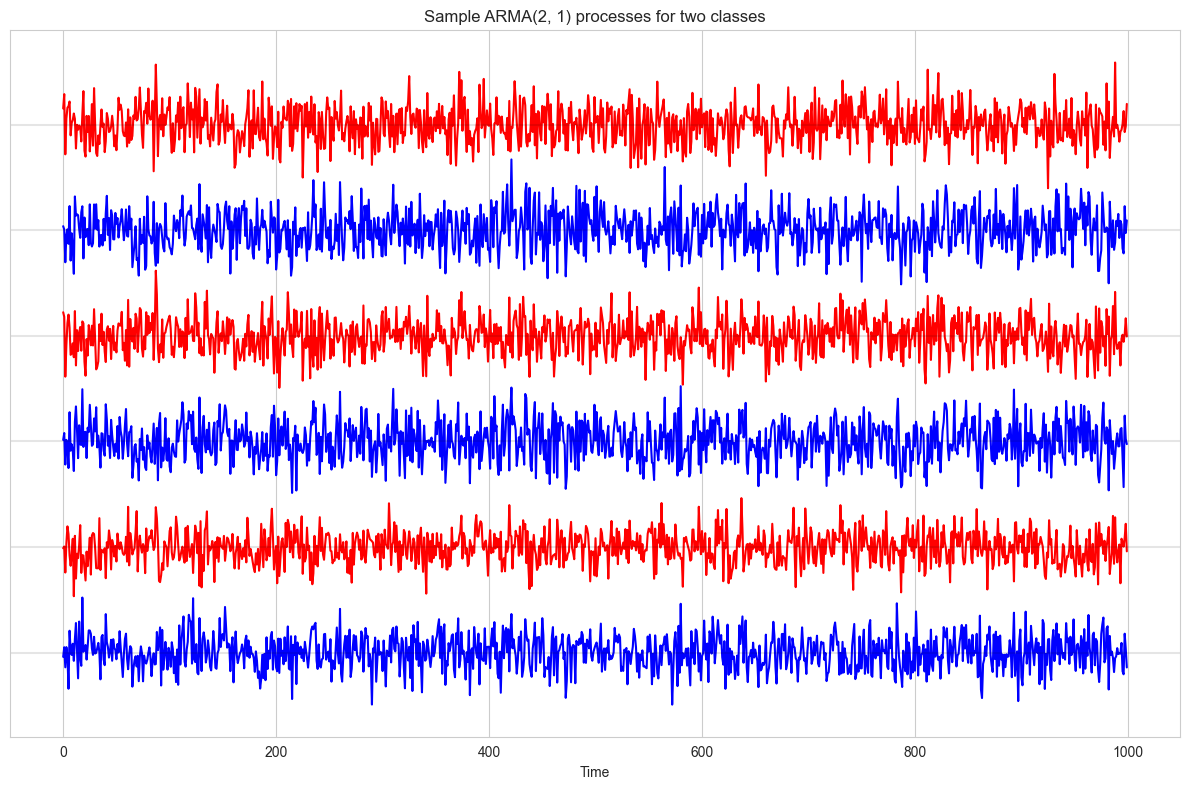

In [4]:
n_plots = 4
fig, ax = plt.subplots(figsize=(12, 8))
vertical_step = 10 # this way we can plot all the processes in the same figure

for i in range(1,n_plots):
    ax.plot(arma_samples_1[i, :]+(2*i)*vertical_step, color='blue')
    ax.axhline((2*i)*vertical_step, color='black', linestyle='-', alpha=0.1)
    ax.plot(arma_samples_2[i, :]+(2*i+1)*vertical_step, color='red')
    ax.axhline((2*i+1)*vertical_step, color='black', linestyle='-', alpha=0.1)

# remove yticks for clarity
ax.set_yticks([])

ax.set_xlabel('Time')
ax.set_title('Sample ARMA(2, 1) processes for two classes')

plt.tight_layout()

Indeed they look quite similar, at least to the human eye.

## 2. Classify

First let's prep the data.

In [5]:
# label the data
X1 = pd.DataFrame(arma_samples_1)
X1['class'] = 0

X2 = pd.DataFrame(arma_samples_2)
X2['class'] = 1

# combine the data
df = pd.concat([X1, X2], axis=0)

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# separate the data
X, y = df.iloc[:,:-1], df.iloc[:,-1]

print(f'X shape: {X.shape}')

X shape: (2000, 1000)


### 2.1 Classification using a simple multilayer perceptron

In [6]:
clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=seed)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
score = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print('Accuracy: {:.2f} +/- {:.2f}'.format(score.mean(), score.std()))

Accuracy: 0.98 +/- 0.01


As expected, a neural network can easily discriminate between these two classes of ARMA processes.

Let's now see how the logistic regression on signature terms fares.

### 2.2 Classification using logistic regression on low-rank signature terms

As usual, we will apply Lead-Lag transform to our signal before computing its signature. Thus we end up with a signal in $\R^2$, meaning that $\mathbb{X}^{LL,k}\in \big(\R^2\big)^{\otimes k}$ is of size $d^k$ and thus $\mathbb{X}^{LL,\leq N}$ contains $1+2+2^2+\cdots + 2^N=2^{N+1}-1$ elements. Since the size of the $N$-truncated signature is exponential in $N$, we want to restrict ourselves to a small values for $N$. Besides, since signature terms decay with their rank $k$ (division by $k!$), we can expect low-rank terms to hold more predictive power.

In [7]:
# util
def LL_transform(batch: torch.Tensor) -> torch.Tensor:
    """
    Lead-Lag transform for a batch of paths.

    Parameters:
    - batch: a batch of paths, of shape (batch_size, path_length, channels)

    Returns:
    - a batch of lead-lag transformed paths, of shape (batch_size, 2*path_length-1, channels)
    
    """
    batch_path_doubled = batch.repeat_interleave(2, dim=1)  # each path is doubled (with neighbors equal)
    batch_lead = batch_path_doubled[:, 1:, :]  # remove the first point of each path
    batch_lag = batch_path_doubled[:, :-1, :]  # remove the last point of each path

    # concatenate lead and lag paths
    batch_path_LL = torch.cat((batch_lead, batch_lag), dim=2)
    return batch_path_LL

Let's first prep the data.

In [8]:
depth = 2 # depth of the signature

# convert the numpy arrays to torch tensors (since signatory works with torch tensors)
tensor_arma_samples_1 = torch.tensor(arma_samples_1).unsqueeze(2)
tensor_arma_samples_2 = torch.tensor(arma_samples_2).unsqueeze(2)

# apply the lead-lag transform
LL_arma_samples_1 = LL_transform(tensor_arma_samples_1)
LL_arma_samples_2 = LL_transform(tensor_arma_samples_2)

# print shape of the lead-lag transformed paths
print(f'Shape of LL_arma_samples_1: {LL_arma_samples_1.shape}')
print(f'Shape of LL_arma_samples_2: {LL_arma_samples_2.shape}')

# compute the signature
sig_1 = signatory.signature(LL_arma_samples_1, depth=depth)
sig_2 = signatory.signature(LL_arma_samples_2, depth=depth)

# print shape of the signatures
print(f'Shape of sig_1: {sig_1.shape}')
print(f'Shape of sig_2: {sig_2.shape}')

# now create the new dataset
X_1 = pd.DataFrame(sig_1.numpy())
X_1['class'] = 0

X_2 = pd.DataFrame(sig_2.numpy())
X_2['class'] = 1

# combine the data
df = pd.concat([X_1, X_2], axis=0)

# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# separate the data
X, y = df.iloc[:,:-1], df.iloc[:,-1]

Shape of LL_arma_samples_1: torch.Size([1000, 1999, 2])
Shape of LL_arma_samples_2: torch.Size([1000, 1999, 2])
Shape of sig_1: torch.Size([1000, 6])
Shape of sig_2: torch.Size([1000, 6])


We can now use the signature terms as features to perform logistic regression. We will explore both $L^1$ and $L^2$ regularization since $L^2$ is faster but $L^1$ is more intuitive since we expect few signature terms to be relevant, especially for large values of $N$ (signature depth).

In [9]:
# using L2 penalty
logreg = LogisticRegression(random_state=seed, max_iter=1000, solver='liblinear')
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')
print('Accuracy: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))
final_model = logreg.fit(X, y)
coefs = final_model.coef_[0]
intercept = final_model.intercept_[0]
print(f'Coefficients: {coefs}')
print(f'Intercept: {intercept}')

Accuracy: 0.98 +/- 0.01
Coefficients: [-0.00178328 -0.00178328  0.00059197 -0.00206202  0.00324595  0.00059197]
Intercept: 17.274259679622617


In [10]:
# using L1 penalty
logreg = LogisticRegression(random_state=seed, max_iter=1000, solver='liblinear', penalty='l1', C=0.1)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
scores = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')
print('Accuracy: {:.2f} +/- {:.2f}'.format(scores.mean(), scores.std()))
final_model = logreg.fit(X, y)
coefs = final_model.coef_[0]
intercept = final_model.intercept_[0]
print(f'Coefficients: {coefs}')
print(f'Intercept: {intercept}')

Accuracy: 0.98 +/- 0.01
Coefficients: [ 0.          0.          0.         -0.00417817  0.00330019  0.        ]
Intercept: 24.378064864944047


Too easy, let's try harder

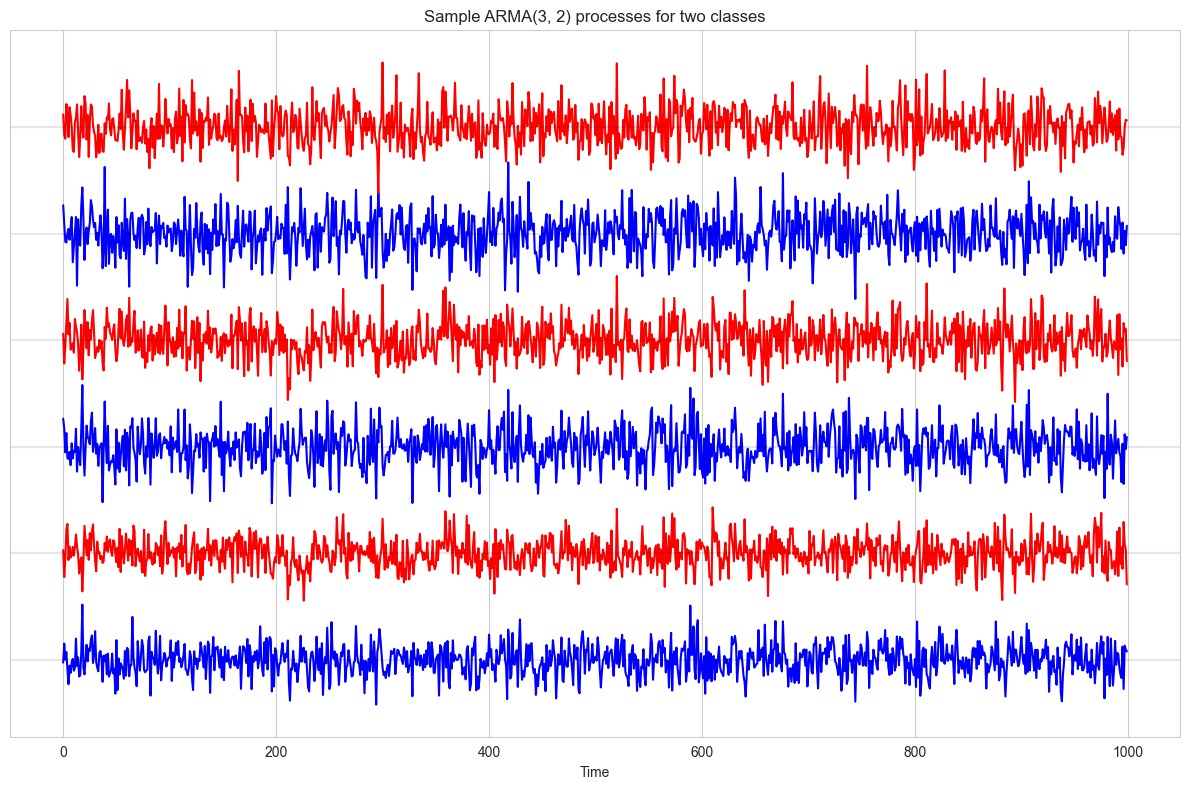

In [57]:
n_samples = 1000 # number of sample ARMA processes of each class
sample_size = 1000 # length of each sample ARMA process

parameters_1 = {'ar': [1, -0.5, 0.2, -0.1], 'ma': [1, 0.5, 0.8]} # parameters of the first ARMA process
parameters_2 = {'ar': [1, -0.5, 0.2, 0.1], 'ma': [1, 0.5, 0.7]} # parameters of the second ARMA process

# generate the samples
arma_samples_1 = arma_generate_sample(**parameters_1, nsample=(n_samples, sample_size))
arma_samples_2 = arma_generate_sample(**parameters_2, nsample=(n_samples, sample_size))

n_plots = 4
fig, ax = plt.subplots(figsize=(12, 8))
vertical_step = 10 # this way we can plot all the processes in the same figure

for i in range(1,n_plots):
    ax.plot(arma_samples_1[i, :]+(2*i)*vertical_step, color='blue')
    ax.axhline((2*i)*vertical_step, color='black', linestyle='-', alpha=0.1)
    ax.plot(arma_samples_2[i, :]+(2*i+1)*vertical_step, color='red')
    ax.axhline((2*i+1)*vertical_step, color='black', linestyle='-', alpha=0.1)

# remove yticks for clarity
ax.set_yticks([])

ax.set_xlabel('Time')
ax.set_title('Sample ARMA(3, 2) processes for two classes')

plt.tight_layout()

In [12]:
def performance_MLP(arma_samples_1, arma_samples_2):
    """
    Function to compute the performance of a MLP classifier on a given dataset.
    """

    X1 = pd.DataFrame(arma_samples_1)
    X1['class'] = 0
    X2 = pd.DataFrame(arma_samples_2)
    X2['class'] = 1
    df = pd.concat([X1, X2], axis=0)
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = df.iloc[:,:-1], df.iloc[:,-1]

    clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=seed)
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    score = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

    return score.mean(), score.std()

def performance_logreg(arma_samples_1, arma_samples_2, depth=3):
    """
    Function to compute the performance of a logistic regression classifier on a given dataset.
    """
    tensor_arma_samples_1 = torch.tensor(arma_samples_1).unsqueeze(2)
    tensor_arma_samples_2 = torch.tensor(arma_samples_2).unsqueeze(2)

    LL_arma_samples_1 = LL_transform(tensor_arma_samples_1)
    LL_arma_samples_2 = LL_transform(tensor_arma_samples_2)

    sig_1 = signatory.signature(LL_arma_samples_1, depth=depth)
    sig_2 = signatory.signature(LL_arma_samples_2, depth=depth)

       
    X_1 = pd.DataFrame(sig_1.numpy())
    X_1['class'] = 0
    X_2 = pd.DataFrame(sig_2.numpy())
    X_2['class'] = 1
    df = pd.concat([X_1, X_2], axis=0)
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = df.iloc[:,:-1], df.iloc[:,-1]

    logreg = LogisticRegression(random_state=seed, max_iter=1000, solver='liblinear')
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    score = cross_val_score(logreg, X, y, cv=cv, scoring='accuracy')
    return score.mean(), score.std()

In [81]:
score_mean, score_std = performance_MLP(arma_samples_1, arma_samples_2)
print('Accuracy: {:.2f} +/- {:.2f}'.format(score_mean, score_std))

Accuracy: 0.98 +/- 0.01


MLP achieves excellent performance again.

In [77]:
max_depth = 6
for N in range(1, max_depth+1):
    score_mean, score_std = performance_logreg(arma_samples_1, arma_samples_2, depth=N)
    print(f'N = {N}: {score_mean:.2f} +/- {score_std:.2f}')

N = 1: 0.51 +/- 0.02
N = 2: 0.79 +/- 0.02
N = 3: 0.79 +/- 0.01
N = 4: 0.79 +/- 0.02
N = 5: 0.79 +/- 0.02
N = 6: 0.80 +/- 0.01


Performance seems to plateau from depth $N=3$.

Let's look at the weights in the logistic regression for a depth $N=4$.

Intercept: 2.457645938091567e-06


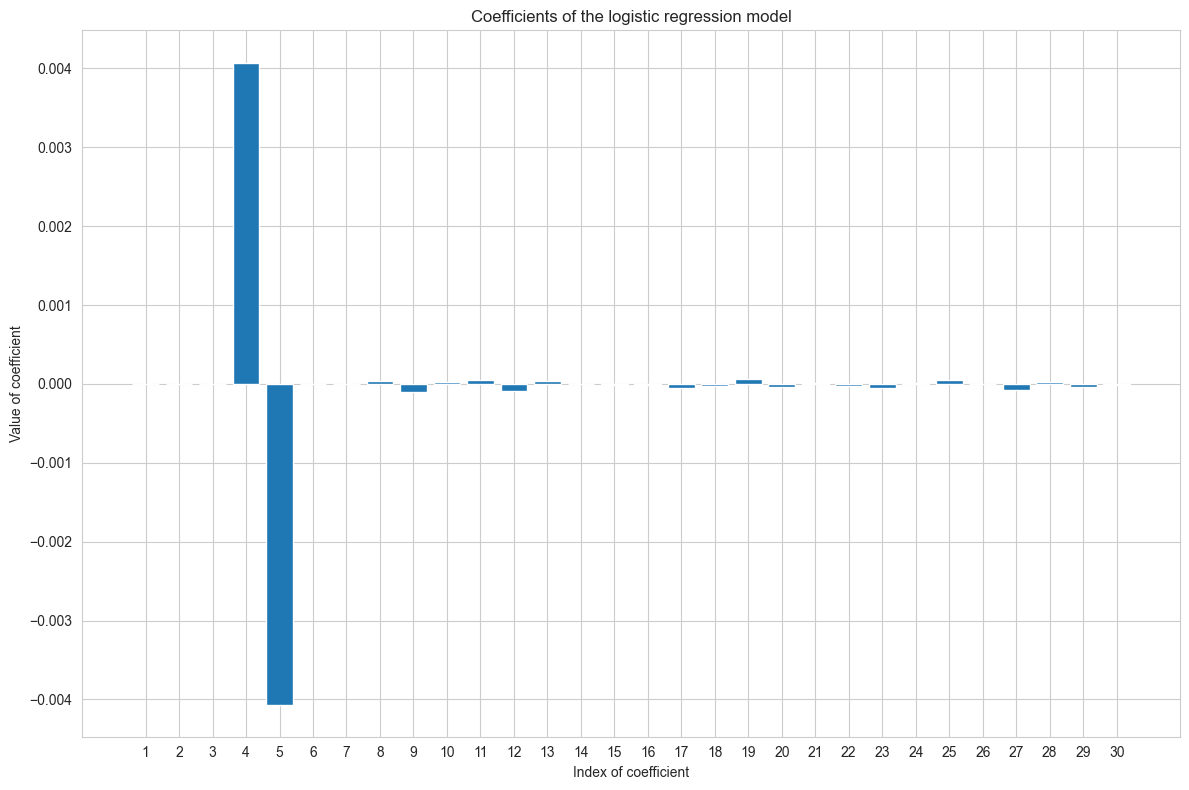

In [80]:
depth = 4

tensor_arma_samples_1 = torch.tensor(arma_samples_1).unsqueeze(2)
tensor_arma_samples_2 = torch.tensor(arma_samples_2).unsqueeze(2)

LL_arma_samples_1 = LL_transform(tensor_arma_samples_1)
LL_arma_samples_2 = LL_transform(tensor_arma_samples_2)

sig_1 = signatory.signature(LL_arma_samples_1, depth=depth)
sig_2 = signatory.signature(LL_arma_samples_2, depth=depth)

       
X_1 = pd.DataFrame(sig_1.numpy())
X_1['class'] = 0
X_2 = pd.DataFrame(sig_2.numpy())
X_2['class'] = 1
df = pd.concat([X_1, X_2], axis=0)
df = df.sample(frac=1).reset_index(drop=True)
X, y = df.iloc[:,:-1], df.iloc[:,-1]

logreg = LogisticRegression(random_state=seed, max_iter=1000, solver='liblinear')
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
logreg = logreg.fit(X, y)
coefs = logreg.coef_[0]
intercept = logreg.intercept_[0]

# plt barplot of the coefficients
print(f'Intercept: {intercept}')
plt.figure(figsize=(12, 8))
plt.bar(range(len(coefs)), coefs)
plt.xticks(range(len(coefs)), range(1, len(coefs)+1))
plt.xlabel('Index of coefficient')
plt.ylabel('Value of coefficient')
plt.title('Coefficients of the logistic regression model')
plt.tight_layout()

Interestingly, weights of order 0 and 1 are negligible. The weights that matter most are of order 2. This is probably because in order to distinguish between the two ARMA(3,2) classes, one needs to look at high order geometric properties of the path, hence higher order signature terms.

## Conclusion

In this notebook we've demonstrated the relevance of using signature terms as embeddings to do machine learning on path data. Although the performance isn't a good as using plain neural networks (simple MLPs here), it is much faster, especially as $n$ the number of points in the path increases (because this increases the size of the MLP input, but not the size of the signature). Besides, signature embedding is still quite novel so we can expect tricks that will make it better in the future.